### Edge elements on triangles
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000
but solved with code from Davidson ("Computational Electromagnetics for RF and Microwave Engineering", 2011)

In [1]:
# helper functions
using LinearAlgebra
include("whitney.jl")
include("meshing.jl")
include("fem.jl")
include("distmesh-julia/test.jl")
include("getmejulia/GetmeJulia.jl")
nothing

In [2]:
# Parameters
ε0 = 1.
μ0 = 1.
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr

a, b = 1.3, 0.9
n, m = 13, 9
nothing

In [3]:
# using PyPlot

# a, b = 1.3, 0.9
# n, m = 13, 9
# LOCALEDGENODES = [1 2; 1 3; 2 3]
# trimesh(a, b, n, m)
# triedgemake()

# figure(figsize=(5,1))
# triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
# axis("equal");

In [4]:
# import Plots
# pv = [-0.4 -0.5;0.4 -0.2;0.4 -0.7;1.5 -0.4;0.9 0.1;
#       1.6 0.8;0.5 0.5;0.2 1;0.1 0.4;-0.7 0.7;-0.4 -0.5]
# fd = p -> dpolygon( p, pv )
# fh = p -> ones(size(p,1))
# h0=0.1
# bbox=[-1 -1;2 1]
# p_fix=pv
# e_fix=[]
# it_max=2000
# (p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
# x = pv[:,1]
# y = pv[:,2]
# plotgrid( p, t )                                                        
# # # y = fd(x)
# Plots.plot!(x, y)
# # scatter!(p[:,1], p[:,2],markersize=1)
# # # scatter!(p[:,1], p[:,2])
# # # pv[:,1]

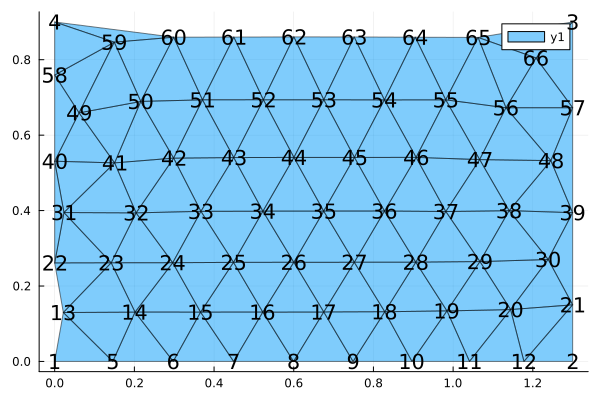

In [5]:
# using PyPlot

a, b = 1.3, 0.9

pv = [0 0; a 0; a b; 0 b; 0 0]
fd = p -> dpolygon( p, pv )
fh = p -> ones(size(p,1))
h0=0.15
bbox=[0 0;a b]
p_fix=pv
e_fix=[]
it_max=10
(p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
sort!(t, dims=2) # element nodes have to be sorted
x = pv[:,1]
y = pv[:,2]
plotgrid( p, t )              
Plots.annotate!(p[:,1], p[:,2], 1:size(p,1))
# # y = fd(x)
# Plots.plot!(x, y)


# a, b = 1.3, 0.9
# n, m = 13, 9
# LOCALEDGENODES = [1 2; 1 3; 2 3]
# trimesh(a, b, n, m)
# triedgemake()

# figure(figsize=(5,1))
# triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
# axis("equal");

In [6]:
p

66×2 Matrix{Float64}:
 0.0       0.0
 1.3       0.0
 1.3       0.9
 0.0       0.9
 0.145735  0.0
 0.29757   0.0
 0.449084  6.42514e-22
 0.599469  9.78227e-12
 0.748875  0.0
 0.896783  2.6628e-21
 1.04111   0.0
 1.17777   0.0
 0.021685  0.129645
 ⋮         
 0.981417  0.693659
 1.13263   0.672555
 1.3       0.672609
 0.0       0.759401
 0.149531  0.84644
 0.298679  0.8597
 0.449646  0.86
 0.60034   0.860458
 0.751661  0.860292
 0.904959  0.859621
 1.06263   0.859019
 1.20791   0.804649

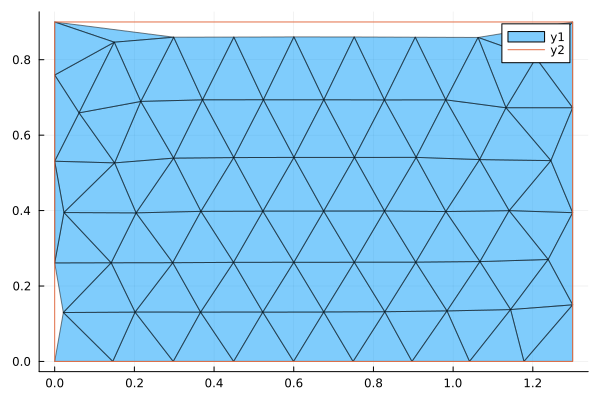

In [7]:
epsilon = 0.001
# bottom_row_points
p[p[:, 1] .< epsilon, 1] .= 0
# top_row_points
p[p[:, 2] .> b - epsilon, 2] .= b
# left_column_points
p[p[:, 2] .< epsilon, 2] .= 0
# right_column_points
p[p[:, 1] .> a - epsilon, 1] .= a


plotgrid( p, t )                                                        
# # y = fd(x)
Plots.plot!(x, y)

In [27]:
import .Smoothing

# function PolygonalMesh(
#   nodes::Vector{Mathematics.Vector2D}, 
#   polygons::Vector{Mathematics.Polygon}, 
#   fixedNodeIndices::Set{Int}=Set{Int}()
# 
nodes = Vector{Mathematics.Vector2D}(undef,size(p,1))
for index in 1:size(p,1)
  nodes[index] = Mathematics.Vector2D(p[index,1], p[index,2])
end
polygons = Vector{Mathematics.Polygon}(undef,size(t,1))
for index in 1:size(t,1)
  polygons[index] = Mathematics.Polygon([t[index,1], t[index,2], t[index,3]])
end
# TODO: fixedNodeIndices
mesh = Mesh.PolygonalMesh(nodes, polygons)
minHeap = Smoothing.PolygonQualityMinHeap(mesh)
plotgrid( p, t )     
for index in size(minHeap.binaryTree,1)
    tree = minHeap.binaryTree[index]
    pg = polygons[tree.polygonIndex]
    n1, n2, n3 = nodes[pg[1]], nodes[pg[2]], nodes[pg3]
    x = (min(n1.x, n2.x, n3.x) + max(n1.x, n2.x, n3.x))/2
    y = (min(n1.y, n2.y, n3.y) + max(n1.y, n2.y, n3.y))/2
    Plots.annotate!(x, y, tree.meanRatioNumber)
end

# config = GetmeSequentialConfig(Mesh.getMaximalNumberOfPolygonNodes(mesh), PolygonTransformationSet.Generic)

# Smoothing.getmeSequential(mesh, config)

LoadError: MethodError: no method matching getindex(::Main.Mathematics.Polygon, ::Int64)

In [3]:
using Test
# using Smoothing

module Testdata

function getMixedSampleMeshNodes()
    return Mathematics.Vector2D[
        Mathematics.Vector2D(0.0, 0.0),   # 0
        Mathematics.Vector2D(5.0, -1.0),  # 1
        Mathematics.Vector2D(7.0, -2.0),  # 2
        Mathematics.Vector2D(9.0, 0.0),   # 3
        Mathematics.Vector2D(9.0, 2.0),   # 4
        Mathematics.Vector2D(9.0, 5.0),   # 5
        Mathematics.Vector2D(6.0, 5.0),   # 6
        Mathematics.Vector2D(3.0, 5.0),   # 7
        Mathematics.Vector2D(0.0, 3.0),   # 8
        Mathematics.Vector2D(6.0, 2.0),   # 9
        Mathematics.Vector2D(3.0, 1.0),   # 10
    ]
end

function getMixedSampleMeshPolygons()
    return Mathematics.Polygon[
        Mathematics.Polygon([1, 2, 11]),       # 0
        Mathematics.Polygon([2, 10, 11]),      # 1
        Mathematics.Polygon([2, 3, 4, 5, 10]), # 2
        Mathematics.Polygon([5, 6, 7, 10]),    # 3
        Mathematics.Polygon([10, 7, 11]),      # 4
        Mathematics.Polygon([7, 8, 9, 11]),    # 5
        Mathematics.Polygon([1, 11, 9]),       # 6
    ]
end

function getMixedSampleMeshFixedNodeIndices()
    return Set([1, 2, 3, 4, 5, 6, 7, 8, 9])
end

function getMixedSampleMesh()
    return Mesh.PolygonalMesh(getMixedSampleMeshNodes(), getMixedSampleMeshPolygons(), getMixedSampleMeshFixedNodeIndices())
end

function getInvalidMixedSampleMesh()
    invalidMesh = getMixedSampleMesh()
    invalidMesh.nodes[10] = Mathematics.Vector2D(17.0, 2.0)
    return invalidMesh
end

end

@testset "MinHeapEntry" begin
    polygonIndex = 17
    polygonMeanRatioNumber = 0.74
    isFixedPolygon = true
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, isFixedPolygon)

    @test Smoothing.getPolygonIndex(entry) == polygonIndex
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == polygonMeanRatioNumber
    @test Smoothing.getMeanRatioNumber(entry) == polygonMeanRatioNumber
    @test Smoothing.isAllFixedNodesPolygon(entry) == isFixedPolygon
end

@testset "MinHeapEntry" begin
    polygonIndex = 3
    polygonMeanRatioNumber = 0.4
    isFixedPolygon = false
    initialPenaltySum = 0.06
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, isFixedPolygon, initialPenaltySum)

    @test Smoothing.getPolygonIndex(entry) == polygonIndex
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == polygonMeanRatioNumber + initialPenaltySum
    @test Smoothing.getMeanRatioNumber(entry) == polygonMeanRatioNumber
    @test Smoothing.isAllFixedNodesPolygon(entry) == isFixedPolygon
end

@testset "MinHeapEntry" begin
    polygonIndex = 3
    polygonMeanRatioNumber = 0.4
    isFixedPolygon = false
    initialPenaltySum = 0.06
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, isFixedPolygon, initialPenaltySum)

    @test Smoothing.getPolygonIndex(entry) == polygonIndex
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == polygonMeanRatioNumber + initialPenaltySum
    @test Smoothing.getMeanRatioNumber(entry) == polygonMeanRatioNumber
    @test Smoothing.isAllFixedNodesPolygon(entry) == isFixedPolygon
end

@testset "MinHeapEntry compareOperators" begin
    orderedEntries = [
        Smoothing.MinHeapEntry(14, 0.2, false, 0.0),
        Smoothing.MinHeapEntry(30, 0.18, false, 0.04),
        Smoothing.MinHeapEntry(9, 0.2, false, 0.02),
        Smoothing.MinHeapEntry(11, 0.2, false, 0.02),
        Smoothing.MinHeapEntry(2, 0.22, false, 0.0),
        Smoothing.MinHeapEntry(4, 0.1, false, 0.13),
        Smoothing.MinHeapEntry(1, 0.1, true, 0.0),
        Smoothing.MinHeapEntry(0, 0.2, true, 0.0)
    ]

    for firstIndex in 1:length(orderedEntries)
        for secondIndex in 1:length(orderedEntries)
            firstEntry = orderedEntries[firstIndex]
            secondEntry = orderedEntries[secondIndex]

            @test (firstIndex < secondIndex) == (firstEntry < secondEntry)
            @test (firstIndex == secondIndex) == (firstEntry == secondEntry)
            @test (firstIndex > secondIndex) == (firstEntry > secondEntry)
        end
    end
end

@testset "MinHeapEntry updateMethods_throwIfPolygonIsFixed" begin
    polygonIndex = 1
    polygonMeanRatioNumber = 0.3
    updatedPolygonMeanRatioNumber = 0.37
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, true, 0.0)

    @test_throws ErrorException Smoothing.updateMeanRatioNumber(entry, updatedPolygonMeanRatioNumber)
    penaltyChange = 0.3
    @test_throws ErrorException Smoothing.updateMeanRatioNumberAndAddToPenaltySum(entry, updatedPolygonMeanRatioNumber, penaltyChange)
end

@testset "MinHeapEntry updateMethods" begin
    polygonIndex = 12
    polygonMeanRatioNumber = 0.33
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, false, 0.0)

    firstPolygonMeanRatioNumberUpdate = 0.4
    Smoothing.updateMeanRatioNumber(entry, firstPolygonMeanRatioNumberUpdate)
    @test Smoothing.getMeanRatioNumber(entry) == firstPolygonMeanRatioNumberUpdate
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == firstPolygonMeanRatioNumberUpdate

    secondPolygonMeanRatioNumberUpdate = 0.6
    penaltyChange = 0.02
    Smoothing.updateMeanRatioNumberAndAddToPenaltySum(entry, secondPolygonMeanRatioNumberUpdate, penaltyChange)
    @test Smoothing.getMeanRatioNumber(entry) == secondPolygonMeanRatioNumberUpdate
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == secondPolygonMeanRatioNumberUpdate + penaltyChange

    # Penalty sum is >= 0.0 check.
    secondPenaltyChange = -1.0
    Smoothing.updateMeanRatioNumberAndAddToPenaltySum(entry, firstPolygonMeanRatioNumberUpdate, secondPenaltyChange)
    @test Smoothing.getMeanRatioNumber(entry) == firstPolygonMeanRatioNumberUpdate
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == firstPolygonMeanRatioNumberUpdate
end

@testset "MinHeapEntry addToPenaltySum" begin
    polygonIndex = 12
    polygonMeanRatioNumber = 0.33
    entry = Smoothing.MinHeapEntry(polygonIndex, polygonMeanRatioNumber, false, 0.0)

    penaltyChange = 0.4
    Smoothing.addToPenaltySum(entry, penaltyChange)
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == polygonMeanRatioNumber + penaltyChange

    # Penalty sum is >= 0.0 check.
    Smoothing.addToPenaltySum(entry, -2.0 * penaltyChange)
    @test Smoothing.getPenaltyCorrectedMeanRatioNumber(entry) == polygonMeanRatioNumber
end

@testset "PolygonQualityMinHeap constructorAndLowestQualityPolygonIndexGetter" begin
    mesh = Testdata.getMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    try
        Smoothing.isConsistent(minHeap)
        @test true
    catch e
        @test false
    end
    @test Smoothing.getLowestQualityPolygonIndex(minHeap) == 1
    @test Smoothing.isConsistent(minHeap)
end
    
struct TestData
    indexOfPolygonToAdjust::Int
    newPolygonMeanRatioNumber::Float64
    penaltyChange::Float64
    expectedNewWorstPolygonIndex::Int
end

@testset "PolygonQualityMinHeap updateTests" begin
    mesh = Testdata.getMixedSampleMesh()
    testCases = [
        TestData(1, 0.6, 0.0, 1),   # Polygon 1 is still worst after update.
        TestData(1, 0.6, 0.1, 1),   # Polygon 1 is still worst after update.
        TestData(1, 0.71, 0.0, 5),  # Polygon 1 is second worst.
        TestData(1, 1.0, 0.1, 5),   # Polygon 1 is best.
        TestData(6, 0.6, 0.0, 6),   # Make polygon 6 worst.
        TestData(4, 0.6, 0.0, 4),   # Make polygon 4 worst.
    ]

    for testData in testCases
        minHeap = Smoothing.PolygonQualityMinHeap(mesh)
        if testData.penaltyChange == 0.0
            Smoothing.updateMeanRatioNumberIfNotFixedPolygon(minHeap, testData.indexOfPolygonToAdjust, testData.newPolygonMeanRatioNumber)
        else
            Smoothing.updateMeanRatioNumberAndAddToPenaltySum(minHeap, testData.indexOfPolygonToAdjust, testData.newPolygonMeanRatioNumber, testData.penaltyChange)
        end
        newWorstPolygonIndex = Smoothing.getLowestQualityPolygonIndex(minHeap)
        @test testData.expectedNewWorstPolygonIndex == newWorstPolygonIndex
        try
            Smoothing.isConsistent(minHeap)
            @test true
        catch e
            @test false
        end
    end
end
    
@testset "PolygonQualityMinHeap addToPenaltySum" begin
    mesh = Testdata.getMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    Smoothing.addToPenaltySum(minHeap, 1, 0.1)  # Make polygon 1 second worst.
    @test Smoothing.getLowestQualityPolygonIndex(minHeap) == 5

    Smoothing.addToPenaltySum(minHeap, 5, 0.1)  # Make polygon 1 worst again.
    @test Smoothing.getLowestQualityPolygonIndex(minHeap) == 1

    Smoothing.addToPenaltySum(minHeap, 1, 0.2)  # Polygon 6 becomes worst.
    @test Smoothing.getLowestQualityPolygonIndex(minHeap) == 6

    try
        Smoothing.isConsistent(minHeap)
        @test true
    catch e
        @test false
    end
end

@testset "PolygonQualityMinHeap isAllFixedMesh notAllFixedNodes" begin
    mesh = getMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    @test !Smoothing.isAllFixedMesh(minHeap)
end

@testset "PolygonQualityMinHeap isAllFixedMesh allFixedNodes" begin
    nodes = Testdata.getMixedSampleMeshNodes()
    polygons = Testdata.getMixedSampleMeshPolygons()
    fixedNodeIndices = Testdata.getMixedSampleMeshFixedNodeIndices()
    push!(fixedNodeIndices, 10, 11)  # Indices are 1-based in Julia
    mesh = Mesh.PolygonalMesh(nodes, polygons, fixedNodeIndices)
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    @test Smoothing.isAllFixedMesh(minHeap)
end

@testset "PolygonQualityMinHeap getQMinStar equalsQMin" begin
    mesh = Testdata.getMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    tolerance = 1.0e-15
    @test abs(Smoothing.getQMinStar(minHeap) - 6.298366572977736e-01) <= tolerance
end

@testset "PolygonQualityMinHeap getQMinStar_differsFromQMin" begin
    nodes = Testdata.getMixedSampleMeshNodes()
    polygons = Testdata.getMixedSampleMeshPolygons()
    fixedNodeIndices = Testdata.getMixedSampleMeshFixedNodeIndices()
    push!(fixedNodeIndices, 11)  # Indices are 1-based in Julia
    mesh = Mesh.PolygonalMesh(nodes, polygons, fixedNodeIndices)
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    tolerance = 1.0e-15
    @test abs(Smoothing.getQMinStar(minHeap) - 7.085662394599952e-01) <= tolerance
end

@testset "PolygonQualityMinHeap getQMinStar_throwIfAllFixedMesh" begin
    nodes =Testdata. getMixedSampleMeshNodes()
    polygons = Testdata.getMixedSampleMeshPolygons()
    fixedNodeIndices = Testdata.getMixedSampleMeshFixedNodeIndices()
    push!(fixedNodeIndices, 10, 11)  # Indices are 1-based in Julia
    mesh = Mesh.PolygonalMesh(nodes, polygons, fixedNodeIndices)
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    @test_throws Exception Smoothing.getQMinStar(minHeap)
end

@testset "PolygonQualityMinHeap containsAnInvalidPolygon" begin
    mesh = Testdata.getMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    @test !Smoothing.containsAnInvalidPolygon(minHeap)

    mesh = Testdata.getInvalidMixedSampleMesh()
    minHeap = Smoothing.PolygonQualityMinHeap(mesh)
    @test Smoothing.containsAnInvalidPolygon(minHeap)
end

Test Summary: | Pass  Total  Time
MinHeapEntry  |    4      4  0.0s
Test Summary: | Pass  Total  Time
MinHeapEntry  |    4      4  0.0s
Test Summary: | Pass  Total  Time
MinHeapEntry  |    4      4  0.0s
Test Summary:                 | Pass  Total  Time
MinHeapEntry compareOperators |  192    192  0.0s
Test Summary:                                    | Pass  Total  Time
MinHeapEntry updateMethods_throwIfPolygonIsFixed |    2      2  0.0s
Test Summary:              | Pass  Total  Time
MinHeapEntry updateMethods |    6      6  0.0s
Test Summary:                | Pass  Total  Time
MinHeapEntry addToPenaltySum |    2      2  0.0s
PolygonQualityMinHeap constructorAndLowestQualityPolygonIndexGetter

: Error During Test at In[3]:160
  Got exception outside of a @test
  UndefVarError: `Mesh` not defined
  Stacktrace:
    [1] getMixedSampleMesh()
      @ Main.Testdata ./In[3]:39
    [2] macro expansion
      @ In[3]:161 [inlined]
    [3] macro expansion
      @ ~/.julia/juliaup/julia-1.10.0+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
    [4] top-level scope
      @ In[3]:161
    [5] eval
      @ ./boot.jl:385 [inlined]
    [6] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
      @ Base ./loading.jl:2070
    [7] softscope_include_string(m::Module, code::String, filename::String)
      @ SoftGlobalScope ~/.julia/packages/SoftGlobalScope/u4UzH/src/SoftGlobalScope.jl:65
    [8] execute_request(socket::ZMQ.Socket, msg::IJulia.Msg)
      @ IJulia ~/.julia/packages/IJulia/Vo51o/src/execute_request.jl:67
    [9] #invokelatest#2
      @ ./essentials.jl:887 [inlined]
   [10] invokelatest
      @ ./essentials.jl

LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m

In [117]:

@testset "Smoothing applyEdgeLengthScaling" begin
    polygon = Mathematics.Polygon([1, 2, 3, 4, 5, 6])  # Indices are 1-based in Julia
    meshNodes = [
        Mathematics.Vector2D(3.0, 5.0),  
        Mathematics.Vector2D(-9.0, -2.0), 
        Mathematics.Vector2D(7.0, 3.0),
        Mathematics.Vector2D(9.0, -7.0), 
        Mathematics.Vector2D(4.0, 4.0),   
        Mathematics.Vector2D(5.0, -9.0)
    ]
    transformedNodes = [
        Mathematics.Vector2D(2.120029401627464, 3.050931073468095),
        Mathematics.Vector2D(-3.993368337253149, -0.308356785127020),
        Mathematics.Vector2D(3.629849854773023, -2.437418888363173),
        Mathematics.Vector2D(7.820578277134416, -2.594900517549698),
        Mathematics.Vector2D(4.845821607436489, 0.038824027685005),
        Mathematics.Vector2D(4.577089196281754, -3.749078910113208)
    ]
    expectedNodes = [
        Mathematics.Vector2D(0.706538394108473, 8.521742056117311),
        Mathematics.Vector2D(-13.663046103965184, 0.625712254157441),
        Mathematics.Vector2D(4.255382016765926, -4.378663234046956),
        Mathematics.Vector2D(14.105718727334228, -4.748824914040057),
        Mathematics.Vector2D(7.113532196663723, 1.441763203056728),
        Mathematics.Vector2D(6.481874769092831, -7.461729365244467)
    ]
    Smoothing.applyEdgeLengthScaling(polygon, meshNodes, transformedNodes)
    tolerance = 1.0e-14
    @test Mathematics.areEqual(expectedNodes, transformedNodes, tolerance)
end

@testset "Smoothing updateMaxSquaredNodeRelocationDistance" begin
    oldNode = Mathematics.Vector2D(3.0, -2.0)
    newNode = Mathematics.Vector2D(1.0, 2.0)
    maxSquaredNodeRelocationDistance = 0.0

    maxSquaredNodeRelocationDistance = Smoothing.updateMaxSquaredNodeRelocationDistance(oldNode, newNode, maxSquaredNodeRelocationDistance)
    @test maxSquaredNodeRelocationDistance == 20.0

    largerMaxValue = 100.0
    maxSquaredNodeRelocationDistance = largerMaxValue
    maxSquaredNodeRelocationDistance = Smoothing.updateMaxSquaredNodeRelocationDistance(oldNode, newNode, maxSquaredNodeRelocationDistance)
    @test maxSquaredNodeRelocationDistance == largerMaxValue
end

@testset "Smoothing transformAndScaleElement" begin
    lambda = 0.3
    theta = pi / 5.0
    transformation = Mathematics.GeneralizedPolygonTransformation(lambda, theta)
    polygon = Mathematics.Polygon([1, 2, 3, 4, 5])  # Indices are 1-based in Julia
    meshNodes = [
        Mathematics.Vector2D(6.0, -8.0), 
        Mathematics.Vector2D(8.0, -4.0), 
        Mathematics.Vector2D(-7.0, 1.0), 
        Mathematics.Vector2D(8.0, 9.0), 
        Mathematics.Vector2D(3.0, 9.0)
    ]
    expectedNodes = [
        Mathematics.Vector2D(+0.955412051458474, -6.836136432133172),
        Mathematics.Vector2D(+9.828471223820758, +2.138754261004771),
        Mathematics.Vector2D(+0.138965075543568, +1.053163587137887),
        Mathematics.Vector2D(+9.598106992441132, +3.244484494788414),
        Mathematics.Vector2D(-2.520955343263935, +7.399734089202100)
    ]
    transformedAndScaledNodes = Smoothing.transformAndScaleElement(transformation, polygon, meshNodes)
    tolerance = 1.0e-14
    @test Mathematics.areEqual(expectedNodes, transformedAndScaledNodes, tolerance)
end

@testset "Smoothing transformScaleAndRelaxElement" begin
    lambda = 0.3
    theta = pi / 5.0
    transformation = Mathematics.GeneralizedPolygonTransformation(lambda, theta)
    polygon = Mathematics.Polygon([1, 2, 3, 4, 5])  # Indices are 1-based in Julia
    meshNodes = [
        Mathematics.Vector2D(6.0, -8.0), 
        Mathematics.Vector2D(8.0, -4.0), 
        Mathematics.Vector2D(-7.0, 1.0), 
        Mathematics.Vector2D(8.0, 9.0), 
        Mathematics.Vector2D(3.0, 9.0)
    ]
    expectedNodes = [
        Mathematics.Vector2D(+2.468788436020932, -7.185295502493220),
        Mathematics.Vector2D(+9.279929856674531, +0.297127982703340),
        Mathematics.Vector2D(-2.002724447119503, +1.037214510996521),
        Mathematics.Vector2D(+9.118674894708793, +4.971139146351890),
        Mathematics.Vector2D(-0.864668740284754, +7.879813862441470)
    ]
    relaxationFactorRho = 0.7
    transformedAndScaledNodes = Smoothing.transformScaleAndRelaxElement(transformation, relaxationFactorRho, polygon, meshNodes)
    tolerance = 1.0e-14
    @test Mathematics.areEqual(expectedNodes, transformedAndScaledNodes, tolerance)
end

@testset "Smoothing iterativelyResetNodesResultingInInvalidElementsSetNewMeshNodesAndUpdateElementQualityNumbers" begin
    mesh = Testdata.getMixedSampleMesh()
    meanRatioNumbers = Mesh.computeMeanRatioQualityNumberOfPolygons(Mesh.getPolygons(mesh), Mesh.getNodes(mesh))
    newNodePositions = Mesh.getNodes(mesh)
    newNodePositions[10] = Mathematics.Vector2D(12.0, 3.0)  # Indices are 1-based in Julia
    newNodePositions[11] = Mathematics.Vector2D(4.0, 3.0)   # Indices are 1-based in Julia
    expectedMesh = copy(mesh)
    Mesh.getMutableNodes(expectedMesh)[11] = newNodePositions[11]  # Indices are 1-based in Julia
    expectedMeanRatioNumbers = Mesh.computeMeanRatioQualityNumberOfPolygons(Mesh.getPolygons(expectedMesh), Mesh.getNodes(expectedMesh))
    expectedMeshQuality = Mesh.MeshQuality(expectedMesh)
    meshQuality = Smoothing.iterativelyResetNodesResultingInInvalidElementsSetNewMeshNodesAndUpdateElementQualityNumbers(newNodePositions, meanRatioNumbers, mesh)
    @test expectedMeshQuality.qMin == meshQuality.qMin
    @test expectedMeshQuality.qMean == meshQuality.qMean
    @test !meshQuality.getNumberOfInvalidElements().has_value()
    @test !meshQuality.getQMinStar().has_value()
    @test Mesh.areEqual(expectedMesh, mesh, 0.0)
    @test expectedMeanRatioNumbers == meanRatioNumbers
    @test Mesh.getNodes(expectedMesh) == newNodePositions
end

@testset "Smoothing checkTransformations" begin
    maxNumberOfPolygonNodes = 5
    transformations = [Mathematics.GeneralizedPolygonTransformation(i) for i in 1:maxNumberOfPolygonNodes]
    @test try
        Smoothing.checkTransformations(maxNumberOfPolygonNodes, transformations)
        true
    catch
        false
    end
end

Test Summary:                    | Pass  Total  Time
Smoothing applyEdgeLengthScaling |    1      1  0.1s
Test Summary:                                    | Pass  Total  Time
Smoothing updateMaxSquaredNodeRelocationDistance |    2      2  0.0s
Test Summary:                      | Pass  Total  Time
Smoothing transformAndScaleElement |    1      1  0.0s
Test Summary:                           | Pass  Total  Time
Smoothing transformScaleAndRelaxElement |    1      1  0.0s
Smoothing iterativelyResetNodesResultingInInvalidElementsSetNewMeshNodesAndUpdateElementQualityNumbers: Error During Test at In[117]:96
  Got exception outside of a @test
  UndefVarError: `Mesh` not defined
  Stacktrace:
    [1] getMixedSampleMesh()
      @ Main.Testdata ./In[102]:39
    [2] macro expansion
      @ In[117]:97 [inlined]
    [3] macro expansion
      @ ~/.julia/juliaup/julia-1.10.0+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
    [4] top-level scope
      @ In[117]:97
 

LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m

In [9]:
# map distmesh results to correct format

NODE_COORD = p
ELEMENTS = t
NUM_NODES = size(NODE_COORD, 1)
NUM_ELEMS = size(ELEMENTS, 1)
LOCALEDGENODES = [1 2; 1 3; 2 3];
triedgemake()
# sets:
# EDGES
# NODE_EDGES
# ELEMENT_EDGES
# NUM_EDGES

In [10]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b)
dof_renumber!(dof, Γ);

In [11]:
S, T = assemble()

([170.9913147668193 -90.23646629263021 … 0.0 0.0; -90.23646629263021 171.07416153858634 … 0.0 0.0; … ; 0.0 0.0 … 197.98113129524722 -91.56137297226041; 0.0 0.0 … -91.56137297226043 200.6030703752577], [0.42105213943478836 0.026956593387984 … 0.0 0.0; 0.026956593387984 0.5561631595488624 … 0.0 0.0; … ; 0.0 0.0 … 0.5922059765398999 0.030100857923912094; 0.0 0.0 … 0.030100857923912094 0.35316871656605586])

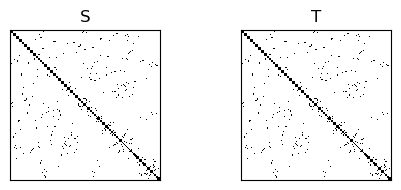

In [12]:
using PyPlot
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

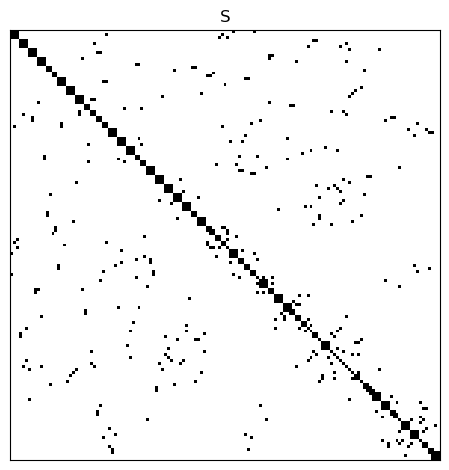

In [13]:
using PyPlot
# figure(figsize=(5, 2))
plot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
# subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [14]:
using LinearAlgebra

k², e = eigen(S, T)

speed_of_light = 299_792_458.
for n in 1:length(k²)
    wavenumber_squared = k²[n]
    if imag(wavenumber_squared) ≈ 0.0
        if real(wavenumber_squared) > 0.0
            frequency = sqrt(abs(wavenumber_squared)) / 2π * speed_of_light
            if 112e6 < frequency < 116e6
                println(n, ". ", 1e-6frequency, "MHz")
            end
        end
    end
end

42. 114.55183795001572MHz


In [15]:
n = 38
x = 0.1:h0:1.2
y = 0.1:h0:0.8
E = evaluate(WhitneyTriangleElement(), e[:, n], dof, x, y)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx = [x for _ in y, x in x]
yy = [y for y in y, _ in x]

figure(figsize=(5, 5))
contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
xlim([-0.1, +1.3])
ylim([-0.1, +0.9])
 xticks([]); yticks([]);

LoadError: InexactError: Float64(4.637975945665517e-16 - 5.246108597168392e-16im)